In [1]:
# loads required imports
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker

from data_integration import combine_data, read_data
import numpy as np
import glob
import os

# needed to read csv faster
import polars as pl 

## Read the dataframes

In [2]:
"""
    Calls the "read_data()" function from file "data_integration.py"
    Calls the "combine_data()" function from file "data_integration.py"
    Parameter:
    - 1: combines only glucose data
    - 2: combines glucose and dempgraphics
    - 3: combines glucose and heartrate
    Output: This function returns the intrgrated dataset included the restricted databases if downloaded and added to folder "datasets for T1D"
 """
# reads the restricted datasets if added to the correct folder
restricted_list = read_data(read_all = False)

In [ ]:
# loads the main dataset including 13 datasets with CGM measurements only if downloaded from OpenHSU
csv_files_maindatabase = sorted(glob.glob(os.path.join('datasets for T1D/maindatabase', '*.csv'))) 
combined_main_list = pd.concat([pd.read_csv(file) for file in csv_files_maindatabase], ignore_index=True)
# polars can be used to read the dataset faster
# combined_main_list = pd.concat([pl.read_csv(file).to_pandas() for file in csv_files_maindatabase], ignore_index=True)

# converts the timestamp column to datetime
combined_main_list["ts"] = pd.to_datetime(combined_main_list["ts"])
# integrates the restricted datasets with modus = 1
combined_main = combine_data(1, restricted_list)  
# combines both dataframes to have the final integrated dataset 
combined_main = pd.concat([combined_main, combined_main_list])
# saves the full integrated main dataset as a csv file
#combined_main.to_csv("datasets for T1D/fullmaindatabase.csv", index=False)

In [ ]:
# load the subdatabase I with CGM data and demographics
combined_subI_list =  pd.read_csv("datasets for T1D/subdatabaseI.csv", dtype={"Age": str})
# polars can be used to read data faster; dataframe needs to be converted to pandas  
# combined_subI_list = pl.read_csv("datasets for T1D/subdatabaseI.csv",schema_overrides={"Age": pl.Utf8})
# combined_subI_list= combined_subI_list.with_columns(pl.col("ts").str.to_datetime())
# combined_subI_list = combined_subI_list.sort(["PtID", "ts"]).to_pandas()

# converts the timestamp column to datetime
combined_subI_list["ts"] = pd.to_datetime(combined_subI_list["ts"])
# integrates the restricted datasets with modus = 2
combined_subI = combine_data(2, restricted_list)
# combines both dataframes to have the final integrated dataset 
combined_subI = pd.concat([combined_subI, combined_subI_list])
# saves the full integrated subdatabase I as a csv file
#combined_subI.to_csv("datasets for T1D/fullsubdatabaseI.csv", index=False)

In [ ]:
# load the subdatabase II with the CGM and HR data; no need to concatenate and save since the restricted databases do not include HR
combined_subII = pd.read_csv("datasets for T1D/subdatabaseII.csv")
# converts the timestamp column to datetime
combined_subII["ts"] = pd.to_datetime(combined_subII["ts"])

# polars can be used to read data faster; dataframe needs to be converted to pandas  
#combined_subII_list = pl.read_csv("datasets for T1D/subdatabaseII.csv")
#combined_subII = combined_subII.with_columns(pl.col("ts").str.to_datetime())
#combined_subII = combined_subII.sort(["PtID", "ts"]).to_pandas()

## Plotting Figures

### Glucose Characteristics

Plots the distribution of glucose characteristics and boxplots for each single database 

/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_92387/1074322492.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_glc_filtered["GLCRange"] = np.select(conditions, choices, default="Euglycemia")


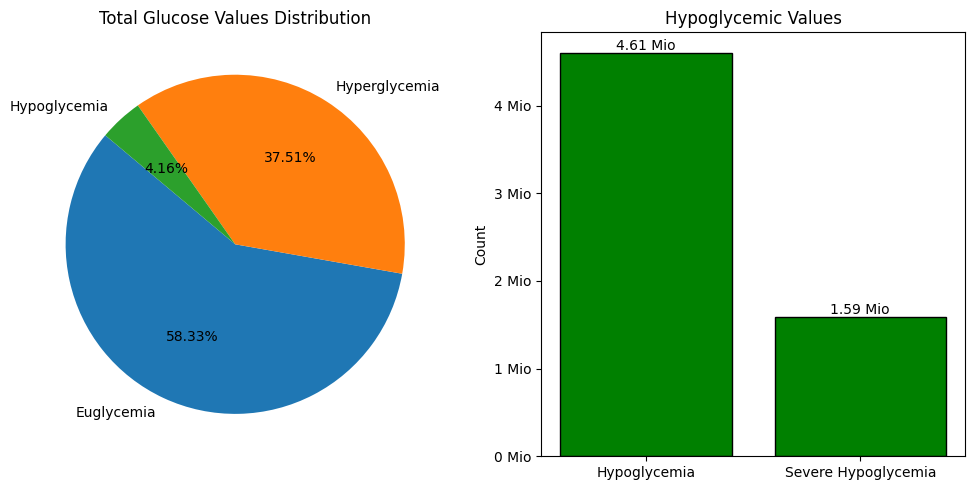

In [ ]:
# plots the distributions of glucose characteristics

# first, missing values are removed
combined_df_glc_filtered = combined_main.dropna(subset=["GlucoseCGM"])

# glucose is labeled with Hypoglycemia, Hyperglycemia, and Euglycemia based on the glucose range and stored in column "GLCRange" 
conditions = [
    (combined_df_glc_filtered["GlucoseCGM"] <= 70),
    (combined_df_glc_filtered["GlucoseCGM"] >= 180)
]
choices = ["Hypoglycemia", "Hyperglycemia"]

# if not Hyperglycemia or Hypoglycemia, the value is set to be Euglycemia
combined_df_glc_filtered["GLCRange"] = np.select(conditions, choices, default="Euglycemia")

# copies the dataframe with labels to also differentiate between level 1 and lLevel 2 Hypoglycemia
combined_plus_sever = combined_df_glc_filtered.copy()
# labels Severe Hypoglycemia based on glucose range 
combined_plus_sever.loc[combined_plus_sever["GlucoseCGM"] <= 54, "GLCRange"] = "Severe Hypoglycemia"
# extracts only hypogylcemic values
filtered_glucose_hypo = combined_plus_sever[(combined_plus_sever["GLCRange"] == "Hypoglycemia") | (combined_plus_sever["GLCRange"] == "Severe Hypoglycemia")]
# groups per label and counts occurrence
glucose_hypo_counts = filtered_glucose_hypo["GLCRange"].value_counts().sort_index()

# function to show both value and percentage
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return f"{val} ({pct:.2f}%)"
    return my_autopct

# groups per label and counts occurrence
glucose_char_counts = combined_df_glc_filtered["GLCRange"].value_counts() 

# plot the distribution of euglycemia, hypoglycemia, hyperglycemia, and plot the distribution of hypoglycemia and severe hypoglycemia as subplots 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# plots the glucose characteristics as a pie chart 
ax1.pie(glucose_char_counts, labels=glucose_char_counts.index, autopct="%1.2f%%", startangle=140)
ax1.set_title("Total Glucose Values Distribution")

# plots the hypogylcemic values as a bar chart
ax2.bar(glucose_hypo_counts.index.astype(str), glucose_hypo_counts.values, width=0.8, edgecolor="black", color = ["green", "green"])
ax2.set_title("Hypoglycemic Values")
ax2.set_ylabel("Count")

# formatter function
def millions(x, pos):
    return f"{x*1e-6:.0f} Mio"

# applies formatter function to the axis to shorten the number to millions
ax2.yaxis.set_major_formatter(FuncFormatter(millions))

# adds text labels on top of each bar
for bar in ax2.patches:
    height = bar.get_height()
    label = f"{height / 1e6:.2f} Mio".rstrip("0").rstrip(".") 
    # converts to millions, cleans up trailing zeros
    ax2.text(bar.get_x() + bar.get_width() / 2, height, label,
             ha="center", va="bottom")

# layout
plt.tight_layout()
plt.show()

<Figure size 800x600 with 0 Axes>

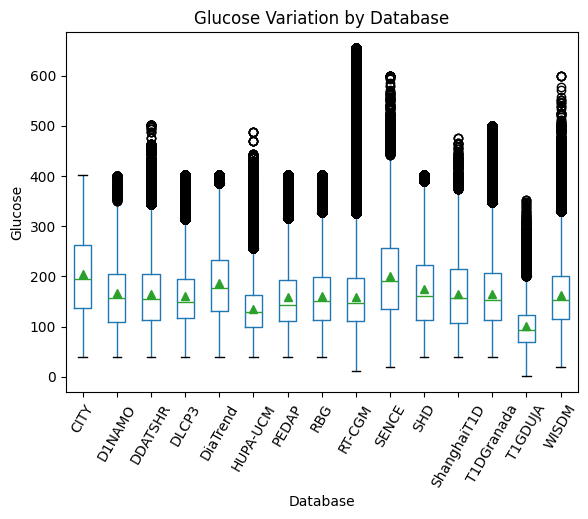

In [46]:
# plots boxplot of glucose values

plt.figure(figsize=(8,6))
# first, drops nan values in the "GlucoseCGM" column
combined_df_g_filtered = combined_main.dropna(subset=["GlucoseCGM"])
# then, plots the glucose variation among databases
combined_df_g_filtered.boxplot(column="GlucoseCGM", by="Database", grid=False,showmeans=True)
# rotates the labels 
plt.xticks(rotation=60)
plt.title("Glucose Variation by Database")
plt.suptitle("") 
plt.xlabel("Database")
plt.ylabel("Glucose")
plt.show()

### Exploring Missing Values 

Plots the missing values count distribution of the main database and also the total number of missing values per single database

/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_94373/1615999656.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=60)
/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_94373/1615999656.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels())


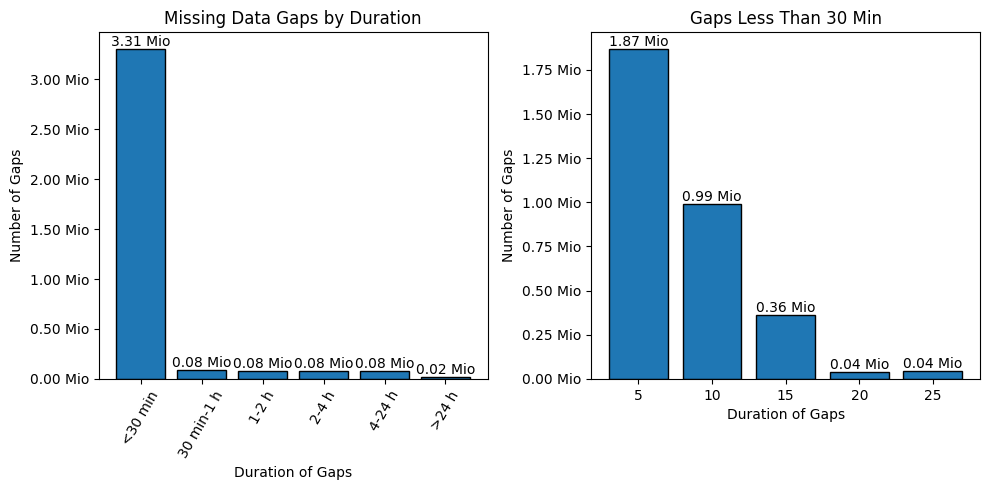

In [45]:

# plots missing values to explore the data quality

# function to show both value and percentage
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        val_mio = round(val / 1_000_000, 1)
        return f"{val} ({pct:.1f}%)"
    return my_autopct

# the dataframe is copied
df_glc_missing = combined_main.copy()
# first, missing blocks are identified 
df_glc_missing["missing"] = df_glc_missing["GlucoseCGM"].isna()

# uses groupby with cumsum to find continuous blocks
df_glc_missing["gap_id"] = (df_glc_missing["missing"] != df_glc_missing["missing"].shift()).cumsum()
# groups by the identified gaps
na_groups = df_glc_missing[df_glc_missing["missing"]].groupby("gap_id").size().reset_index(name="missing_count")
# one row of missing data equals 5 minutes, so the length of gap is multiplied by 5
na_groups["missing_count_time"] = na_groups["missing_count"] * 5

# categorizes durations based on specified bins and labels
bins = [0,30,60,120,240,1440, na_groups["missing_count_time"].max()]
labels = [
    "<30 min",
    "30 min-1 h",
    "1-2 h",
    "2-4 h",
    "4-24 h",
    ">24 h"
]

# converts durations to timedelta seconds for binning
duration_bins = pd.cut(na_groups["missing_count_time"], bins=bins, labels=labels, right=False)

# counts number of gaps per duration range
gap_counts = duration_bins.value_counts().sort_index()

# creates the bin groups
na_groups["MissingGroup"] = pd.cut(na_groups["missing_count_time"], bins=bins, labels=labels, right=False)
# filters to only less than 30 minute gaps
count_30_missing = na_groups[na_groups["MissingGroup"] ==  "<30 min"]["missing_count_time"].value_counts()

# plots the missing values count per created group and for the second group of less than 30 minutes in 5 minute intervals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# plots the barchart of all missing value groups
ax1.bar(gap_counts.index.astype(str), gap_counts.values, edgecolor = "black")
ax1.set_title("Missing Data Gaps by Duration")
ax1.set_xlabel("Duration of Gaps")
ax1.set_ylabel("Number of Gaps")

# formatter function
def millions(x, pos):
    return f"{x*1e-6:.2f} Mio"

# applyies formatter to axis
ax1.yaxis.set_major_formatter(FuncFormatter(millions))
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=60)

# plots the numbers on the bar
for bar in ax1.patches:
    height = bar.get_height()
    # Converts to millions, cleans up trailing zeros
    label = f"{height / 1e6:.2f} Mio".rstrip("0").rstrip(".")  
    ax1.text(bar.get_x() + bar.get_width() / 2, height, label,
             ha="center", va="bottom")


count_30_missing = count_30_missing.sort_index()
# plots the missing values distribution less than 30 minutes as a bar chart
ax2.bar(count_30_missing.index.astype(str), count_30_missing.values, width=0.8, edgecolor="black")
ax2.set_title("Gaps Less Than 30 Min")
ax2.set_xlabel("Duration of Gaps")
ax2.set_ylabel("Number of Gaps")

# adda text labels on top of each bar
for bar in ax2.patches:
    height = bar.get_height()
    # Converts to millions, cleans up trailing zeros
    label = f"{height / 1e6:.2f} Mio".rstrip("0").rstrip(".")  
    ax2.text(bar.get_x() + bar.get_width() / 2, height, label,
             ha="center", va="bottom")

# applies formatter to axis 
ax2.yaxis.set_major_formatter(FuncFormatter(millions))
ax2.set_xticklabels(ax2.get_xticklabels())

# layout
plt.tight_layout()
plt.show()

/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_94373/3163290837.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f"{int(tick/1_000_000)} Mio" for tick in plt.gca().get_yticks()])


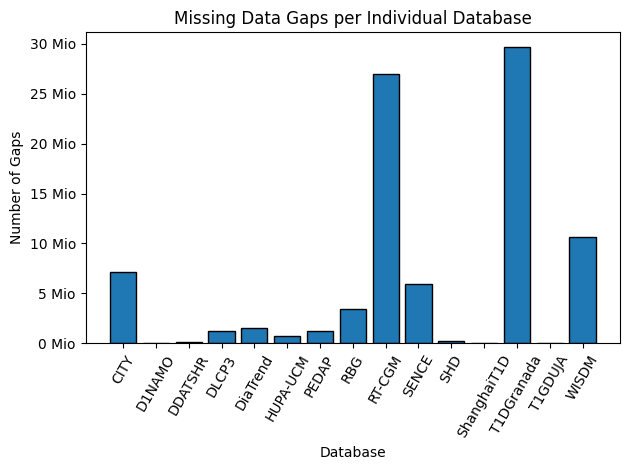

In [44]:
# copies the main database
df_glc = combined_main.copy()
# groups per single database and counts the total number of missing values per database
df_missing_counts = df_glc["GlucoseCGM"].isnull().groupby(df_glc["Database"]).sum()

# plots missing values per single database as a bar chart 
bars = plt.bar(df_missing_counts.index.astype(str), df_missing_counts.values, edgecolor="black")

# converts numbers to millions on the y axis, cleans up trailing zeros
plt.gca().set_yticklabels([f"{int(tick/1_000_000)} Mio" for tick in plt.gca().get_yticks()])
# rotates labels 
plt.xticks(rotation=60)
plt.title("Missing Data Gaps per Individual Database")
plt.xlabel("Database")
plt.ylabel("Number of Gaps")
# layout
plt.tight_layout()
plt.show()

### Analysis of Demographics

Plots the distribution of demographics (age and sex) of subdatabase II 

In [6]:
# sorts by lower bound of the range since the plots are not ordered by the age range
def get_lower_bound(range_str):
    # extracts the first number of the age range, converts it to an integer, and returns the value 
    try:
        return int(range_str.split("-")[0])
    except: 
        return int(range_str.split("+")[0])

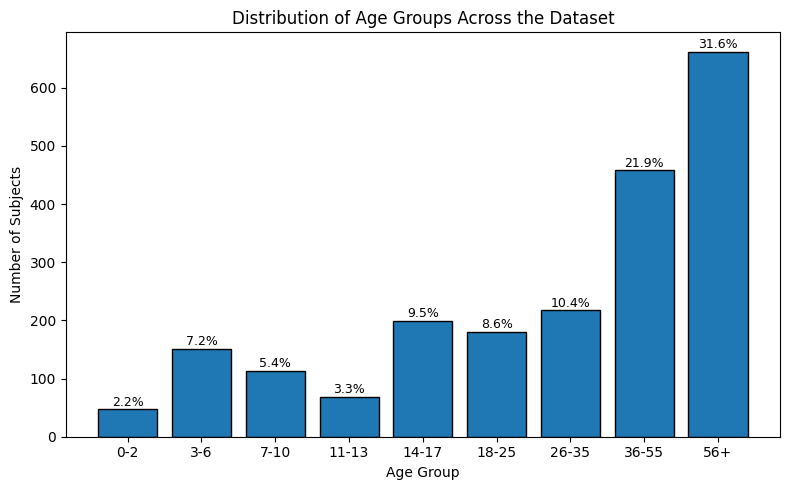

In [17]:
# plots the distribution of age groups across Subdataset I

# first, the dataset is copied 
df = combined_subI.copy()
# then, each PtID is extracted as well as the corresponding age group
df_demo_only_ages = df.drop_duplicates(subset="PtID")[["PtID", "AgeGroup"]]

# counts subjects per age group
age_counts = df_demo_only_ages["AgeGroup"].value_counts().reset_index()
age_counts.columns = ["age_range", "count"]

# orders based on age groups by calling the "get_lower_bound()"" function
age_counts["lower_bound"] = age_counts["age_range"].apply(get_lower_bound)
age_counts = age_counts.sort_values("lower_bound")

# count the number of subjects per age group
total = age_counts["count"].sum()

# calculates the percentage for plotting
percentages = (age_counts["count"] / total * 100).round(1)

# plots the bar plot of grouped ages
plt.figure(figsize=(8, 5))
bars = plt.bar(age_counts["age_range"], age_counts["count"], width=0.8, edgecolor="black")
plt.title("Distribution of Age Groups Across the Dataset")
plt.xlabel("Age Group")
plt.ylabel("Number of Subjects")

# adds percentage labels
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f"{pct}%", 
                ha="center", va="bottom", fontsize=9)

# layout
plt.tight_layout()
plt.show()

/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_91359/2706079980.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f"{int(tick/1_000_000)} Mio" for tick in plt.gca().get_yticks()])


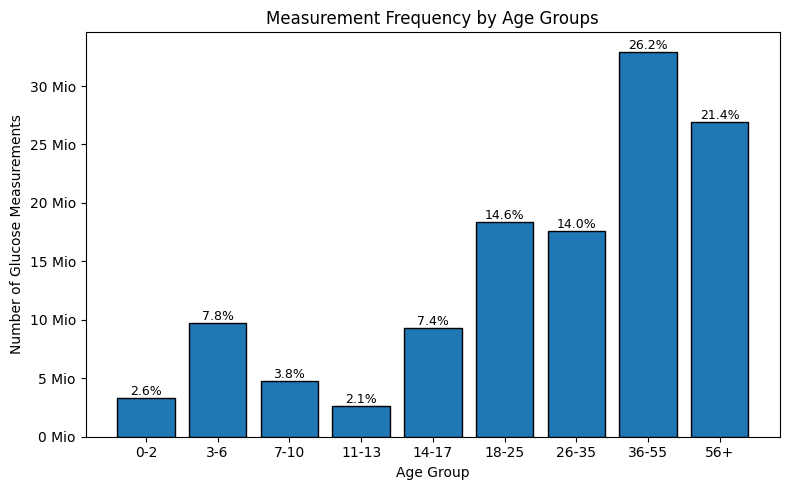

In [25]:
# plots the distribution of all ages and the number of glucose measurements

# first, null values of the "GlucoseCGM" column are removed
combined_subI2_filtered = combined_subI.dropna(subset=["GlucoseCGM"])
# then, the number of patients in each group are count
glucoseage_counts = combined_subI2_filtered["AgeGroup"].value_counts().reset_index()
glucoseage_counts.columns = ["age_range", "count"]

# orders labels based on the age group 
glucoseage_counts["lower_bound"] = glucoseage_counts["age_range"].apply(get_lower_bound)
glucoseage_counts = glucoseage_counts.sort_values("lower_bound")

# counts the number of glucose measurements
total = glucoseage_counts["count"].sum()

# calculates the percentage for plotting
percentages = (glucoseage_counts["count"] / total * 100).round(1)

# plots the number of glucose measurements per database as a bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(glucoseage_counts["age_range"], glucoseage_counts["count"], width=0.8, edgecolor="black")
plt.title("Measurement Frequency by Age Groups")
plt.xlabel("Age Group")
plt.ylabel("Number of Glucose Measurements")

# adds percentage labels
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width()/2, height + 1, f"{pct}%", 
                    ha="center", va="bottom", fontsize=9)

# shortens the number into millions, cleans up trailing zeros
plt.gca().set_yticklabels([f"{int(tick/1_000_000)} Mio" for tick in plt.gca().get_yticks()])
plt.tight_layout()
plt.show()

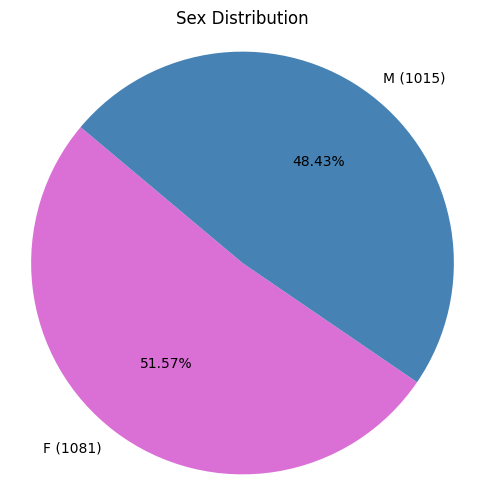

In [25]:

# plots the distribution of sex across Subdatabase I

# first, the PtIDs and the corresponding sex are extracted
df_demo_only_sex = combined_subI.drop_duplicates(subset="PtID")[["PtID", "Sex"]]
# then, the number of subjects per sex are count 
gender_counts = df_demo_only_sex["Sex"].value_counts().sort_index()
gender_counts.index.astype(str)

# the number of counts are plotted next to the label
labels = [f"{category} ({count})" for category, count in zip(gender_counts.index, gender_counts.values)]

# plotting of the pie chart for the distribution of subjects per sex
plt.figure(figsize=(6, 6))
plt.pie(gender_counts, labels=labels, autopct="%1.2f%%" , startangle=140,colors= {"orchid", "steelblue"})
plt.title("Sex Distribution")
plt.axis("equal")
plt.show()

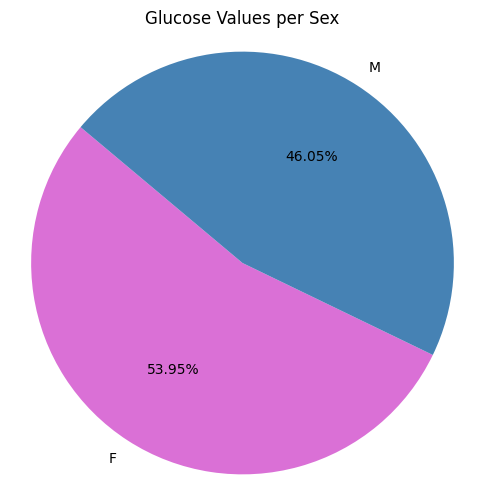

In [24]:
# plots the glucose value count for each sex 

# takes the prior filtered dataframe without null values in the "GlucoseCGM" column and counts the glucose values per sex
glucosegender_counts = combined_subI2_filtered["Sex"].value_counts().sort_index()

# plots the pie chart
plt.figure(figsize=(6, 6))
plt.pie(glucosegender_counts, labels=glucosegender_counts.index, autopct="%1.2f%%", startangle=140, colors = {"orchid", "steelblue"})
plt.title("Glucose Values per Sex")
plt.axis("equal")  
plt.show()

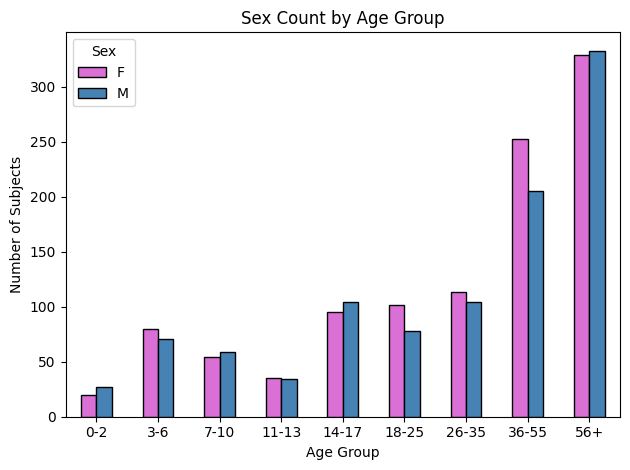

In [21]:
# extract the PtIDs and the corresponsing age groups and sex
df_demo_only = combined_subI.drop_duplicates(subset="PtID")[["PtID", "AgeGroup", "Sex"]]

# counts the number of subjects per age groups and per sex in each age group
counts = df_demo_only.groupby(["AgeGroup", "Sex"]).size().unstack(fill_value=0).reset_index()

# orders based on the age group
counts["lower_bound"] = counts["AgeGroup"].apply(get_lower_bound)
counts = counts.sort_values("lower_bound")

# sets "AgeGroup" back as index for plotting
counts = counts.set_index("AgeGroup").drop(columns=["lower_bound"])

# plots the distribution of age and sex as a bar chart
ax = counts.plot.bar(rot=0, color={"F": "orchid", "M": "steelblue"}, edgecolor="black")
plt.title("Sex Count by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Number of Subjects")
plt.legend(title="Sex")
# layout
plt.tight_layout()
plt.show()

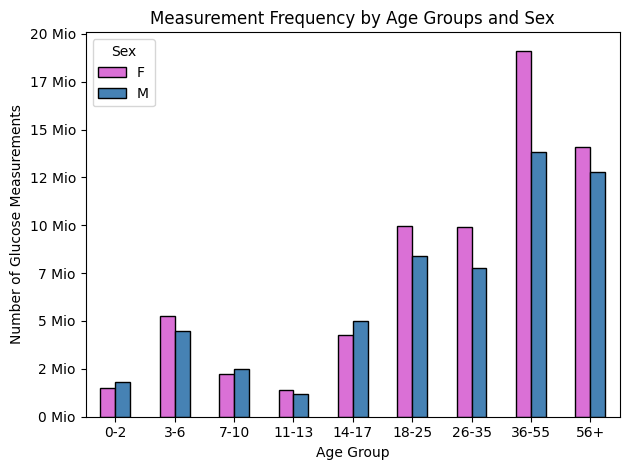

In [22]:
# plots the distribution of glucose measurements per sex and age group

# takes the prior filtered dataframe with no null values in the "GlucoseCGM" column
combined_subI2_filtered = combined_subI.dropna(subset=["GlucoseCGM"])

# counts the number of glucose values per age group and per sex in each age group
counts_demo = combined_subI2_filtered.groupby(["AgeGroup", "Sex"]).size().unstack(fill_value=0).reset_index()

# orders based on age groups 
counts_demo["lower_bound"] = counts_demo["AgeGroup"].apply(get_lower_bound)
counts_demo = counts_demo.sort_values("lower_bound")

# sets "AgeGroup" back as index for plotting
counts_demo = counts_demo.set_index("AgeGroup").drop(columns=["lower_bound"])

# plots the number of glucose measurements per sex and age group as bar charts
ax = counts_demo.plot.bar(rot=0, color={"F": "orchid", "M": "steelblue"}, edgecolor="black")
plt.title("Measurement Frequency by Age Groups and Sex")
plt.xlabel("Age Group")
plt.ylabel("Number of Glucose Measurements")
plt.legend(title="Sex", loc="upper left")
# Converts to millions, cleans up trailing zeros
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x/1_000_000)} Mio"))
# layout
plt.tight_layout()
plt.show()

/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_91359/4073697822.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_subI2_filtered["lower_bound"] = combined_subI2_filtered["AgeGroup"].apply(get_lower_bound)


<Figure size 800x600 with 0 Axes>

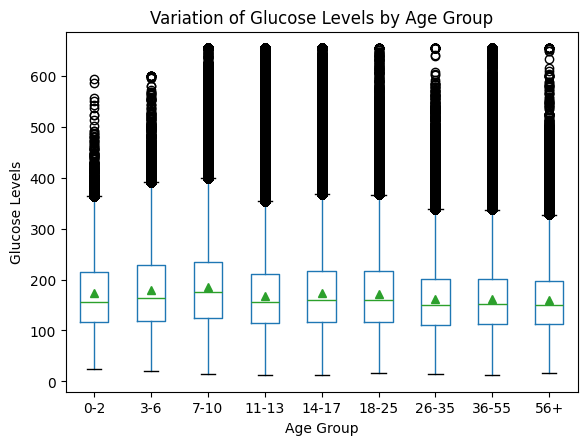

In [31]:
# plots boxplot of the variation of glucose levels across age groups

# first, the nan values in the "GlucoseCGM" column are removed
combined_subI2_filtered = combined_subI.dropna(subset=["GlucoseCGM"])

# then, the dataframe is ordered based on the age group
combined_subI2_filtered["lower_bound"] = combined_subI2_filtered["AgeGroup"].apply(get_lower_bound)
combined_subI2_filtered = combined_subI2_filtered.sort_values("lower_bound")

# creates correct order list
age_order = combined_subI2_filtered[["AgeGroup", "lower_bound"]].drop_duplicates().sort_values("lower_bound")["AgeGroup"].tolist()

# makes "AgeGroup" a categorical with correct order to enable plotting 
combined_subI2_filtered["AgeGroup"] = pd.Categorical(combined_subI2_filtered["AgeGroup"], categories=age_order, ordered=True)

# plots the boxplots
plt.figure(figsize=(8,6))
combined_subI2_filtered.boxplot(column="GlucoseCGM", by="AgeGroup", grid=False,showmeans=True)
plt.title("Variation of Glucose Levels by Age Group")
plt.suptitle("")  
plt.xlabel("Age Group")
plt.ylabel("Glucose Levels")
plt.show()

<Figure size 800x600 with 0 Axes>

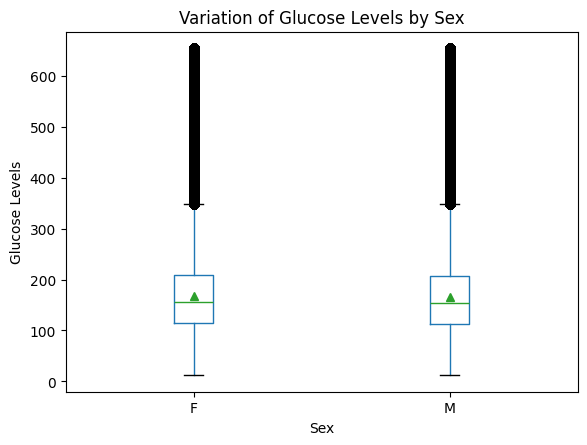

In [32]:
# plots boxplot of the variation of glucose levels among sex
plt.figure(figsize=(8,6))
combined_subI2_filtered.boxplot(column="GlucoseCGM", by="Sex", grid=False,showmeans=True)
plt.title("Variation of Glucose Levels by Sex")
plt.suptitle("")  
plt.xlabel("Sex")
plt.ylabel("Glucose Levels")
plt.show()

### Heart-rate Analysis

<Figure size 800x600 with 0 Axes>

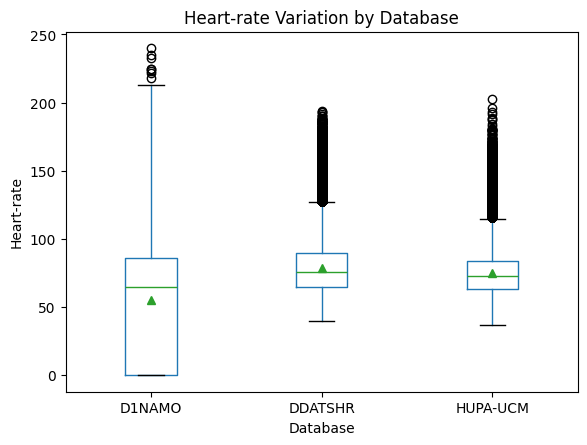

In [39]:
# plots the boxplot for heartrate variation across single databases
plt.figure(figsize=(8,6))
# first, missing values in the "HR" column are removed
combined_df_v_filtered = combined_subII.dropna(subset=["HR"])
# then, the boxplot is plotted per single database 
combined_df_v_filtered.boxplot(column="HR", by="Database", grid=False,showmeans=True)
plt.title("Heart-rate Variation by Database")
plt.suptitle("")  
plt.xlabel("Database")
plt.ylabel("Heart-rate")
plt.show()

/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_94373/1130440348.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=60)
/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_94373/1130440348.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels())


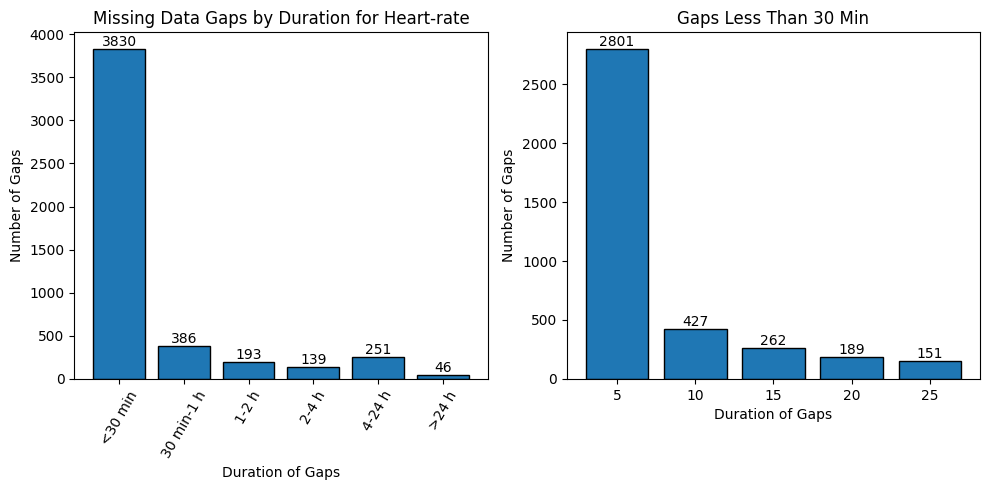

In [47]:
# Plot missing values of the heartrate column for subdatabase II 

# function to show both value and percentage
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        val_mio = round(val / 1_000_000, 1)
        return f"{val} ({pct:.1f}%)"
    return my_autopct

# identifies missing blocks in the heartrate colum
df_glc_missing = combined_subII.copy()
df_glc_missing["missing"] = df_glc_missing["HR"].isna()

# uses groupby with cumsum to find continuous blocks
df_glc_missing["gap_id"] = (df_glc_missing["missing"] != df_glc_missing["missing"].shift()).cumsum()
na_groups = df_glc_missing[df_glc_missing["missing"]].groupby("gap_id").size().reset_index(name="missing_count")
# multiplies by 5 since one missing value euquals 5 minutes
na_groups["missing_count_time"] = na_groups["missing_count"] * 5

# categorizes durations based on specified bins and labels
bins = [0,30,60,120,240,1440, na_groups["missing_count_time"].max()]
labels = [
    "<30 min",
    "30 min-1 h",
    "1-2 h",
    "2-4 h",
    "4-24 h",
    ">24 h"
]

# converts durations to timedelta seconds for binning
duration_bins = pd.cut(na_groups["missing_count_time"], bins=bins, labels=labels, right=False)

# counts number of gaps per duration range
gap_counts = duration_bins.value_counts().sort_index()

# creates bins as column, and filters to less than 30 minute gaps
na_groups["MissingGroup"] = pd.cut(na_groups["missing_count_time"], bins=bins, labels=labels, right=False)
# plots only gaps less than 30 minutes in 5 minute intervals
count_30_missing = na_groups[na_groups["MissingGroup"] ==  "<30 min"]["missing_count_time"].value_counts()

# plots the count of missing values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# first, plots the total number of missing values based on specified categories as a bar chart
ax1.bar(gap_counts.index.astype(str), gap_counts.values, edgecolor="black")
ax1.set_title("Missing Data Gaps by Duration for Heart-rate")
ax1.set_xlabel("Duration of Gaps")
ax1.set_ylabel("Number of Gaps")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=60)

# plots the number on the top of each bar
for bar in ax1.patches:
    height = bar.get_height()
    label = f"{height:.2f}".rstrip("0").rstrip(".")  # Converts to millions, cleans up trailing zeros
    ax1.text(bar.get_x() + bar.get_width() / 2, height, label,
             ha="center", va="bottom")
    
# second, plots the missing values less than 30 minutes in 5 minute intervals as a bar chart
ax2.bar(count_30_missing.index.astype(str), count_30_missing.values, width=0.8, edgecolor="black")
ax2.set_title("Gaps Less Than 30 Min")
ax2.set_xlabel("Duration of Gaps")
ax2.set_ylabel("Number of Gaps")

# adds text labels on top of each bar
for bar in ax2.patches:
    height = bar.get_height()
    label = f"{height:.2f}".rstrip("0").rstrip(".")  # Converts to millions, cleans up trailing zeros
    ax2.text(bar.get_x() + bar.get_width() / 2, height, label,
             ha="center", va="bottom")
    
ax2.set_xticklabels(ax2.get_xticklabels())
# layout
plt.tight_layout()
plt.show()

In [4]:
# assign classes which define the time range before a hypoglycemic event
import datetime
def class_generation(df_copy: pd.DataFrame, timestamp_col: str, start: int, end: int, class_number: int) -> pl.DataFrame: 
    """
    This function is used to assign labels.
    Parameters:
   - df_copy is the original pandas dataframe, 
   - timestamp_col is the name of the column with the timestamps, 
   - start is time in minutes of the minimum duration before hypogylcemia
   - end is time in minutes of the maximum duration before hypogylcemia
   - class_number is the class for the defined time range before hypoglycemia
    Output: It returns the dataframe with the assigned class for the spefied time range before hypoglycemia.
   """ 
    # first, the dataframe is converted to polars to increase efficacy
    df = pl.from_pandas(df_copy)
    # timestamps are sorted 
    df = df.sort(timestamp_col)
    
    # zero events are hypoglycemic data points
    # these are selected and the timestamps are stores as a series
    event_times = df.filter(pl.col("Class") == 0).select(timestamp_col).to_series()

    # the start and end time of the time range before hypogylcemia are computed
    start_bounds = event_times - datetime.timedelta(minutes=start)
    end_bounds = event_times - datetime.timedelta(minutes=end)

    # the series is masked 
    mask = pl.Series([False] * df.height)

    # timestamps meeting the defined criteria of specified time bonds are identified 
    # moreover, the class should be -1 (not assinged as other classes before)
    for start_time, end_time in zip(start_bounds, end_bounds):
        window_mask = (
            (df[timestamp_col] > end_time) &
            (df[timestamp_col] <= start_time) &
            (df["Class"] == -1)
        )
        mask = mask | window_mask

    df = df.with_columns([
        pl.when(mask).then(class_number).otherwise(pl.col("Class")).alias("Class")
    ])

    # the dataframe is converted back to pandas 
    df_pd = df.to_pandas()
    # the dataframe with assigned classes is returned
    return df_pd


# initially all classes are assigned a class -1
classes_df = combined_subII.copy()
classes_df["Class"] = -1
# hypoglycemic values are defined as class 0 with values equal and lower than 70 mg/dL
classes_df.loc[classes_df["GlucoseCGM"] <= 70, "Class"] = 0
classes_df = classes_df.sort_values(by=["PtID", "ts"])

classes_df = classes_df.groupby("PtID", group_keys=False).apply(lambda x: class_generation(x,"ts", 5, 15, 1))
classes_df = classes_df.groupby("PtID", group_keys=False).apply(lambda x: class_generation(x,"ts",15, 30, 2))
classes_df = classes_df.groupby("PtID", group_keys=False).apply(lambda x: class_generation(x,"ts", 30, 60, 3))
classes_df = classes_df.groupby("PtID", group_keys=False).apply(lambda x: class_generation(x,"ts", 60, 125, 4))

classes_df.loc[classes_df["Class"] == -1, "Class"] = 5

# sorts the glucose values by patient id and timestamps
classes_df = classes_df.sort_values(by=["PtID", "ts"])
# reindexes based on the sorted dataset
classes_df= classes_df.reset_index(drop=True)

In [ ]:
# computes the population correaltions considering all values at once separately for pearson, spearman and kendall correaltion methods
pearson_corr = classes_df['GlucoseCGM'].corr(classes_df['HR'], method = 'pearson')
spearman_corr = classes_df['GlucoseCGM'].corr(classes_df['HR'], method = 'spearman')
kendall_corr = classes_df['GlucoseCGM'].corr(classes_df['HR'], method = 'kendall')

# prints the outcomes separately
print(f"Pearson correlation: {pearson_corr:.6f}")
print(f"Spearman correaltion: {spearman_corr:.6f}")
print(f"Kendall correlation: {kendall_corr:.6f}")

Pearson correlation: 0.071827
Spearman correaltion: 0.073365
Kendall correlation: 0.049449


In [26]:
# computes the mean correaltions across all subjects
methods = ['pearson', 'kendall', 'spearman'] 

for method in methods:
    # groups by patient and computes correlation
    correlations = (
        classes_df
        .groupby("PtID")
        .apply(lambda group: group['GlucoseCGM'].corr(group['HR'], method=method))
    )

    # converts to numeric and drops NaNs 
    correlations = correlations.dropna()

    # computes mean correlation across patients
    mean_corr = correlations.mean()

    print(f"Mean {method} correlation across patients: {mean_corr:.4f}")

Mean pearson correlation across patients: 0.0362
Mean kendall correlation across patients: 0.0262
Mean spearman correlation across patients: 0.0383


In [ ]:
# computes the pearson correlation for each class representing time ranges before hypoglycemia
pearson_by_class = classes_df.groupby('Class').apply(lambda g: g['GlucoseCGM'].corr(g['HR']))
print(pearson_by_class)

Class
0    0.101507
1    0.154026
2    0.277275
3    0.242472
4    0.155891
5    0.087661
dtype: float64


In [ ]:
# computes the spearman correlation for each class representing time ranges before hypoglycemia
spearman_by_class = classes_df.groupby('Class').apply(lambda g: g['GlucoseCGM'].corr(g['HR'], method = "spearman"))
print(spearman_by_class)

Class
0    0.094679
1    0.162529
2    0.287381
3    0.279688
4    0.211722
5    0.091104
dtype: float64


In [ ]:
# computes the kendall correlation for each class representing time ranges before hypoglycemia
kendall_by_class = classes_df.groupby('Class').apply(lambda g: g['GlucoseCGM'].corr(g['HR'], method = "kendall"))
print(kendall_by_class)

Class
0    0.063724
1    0.112034
2    0.198559
3    0.192642
4    0.145282
5    0.061405
dtype: float64


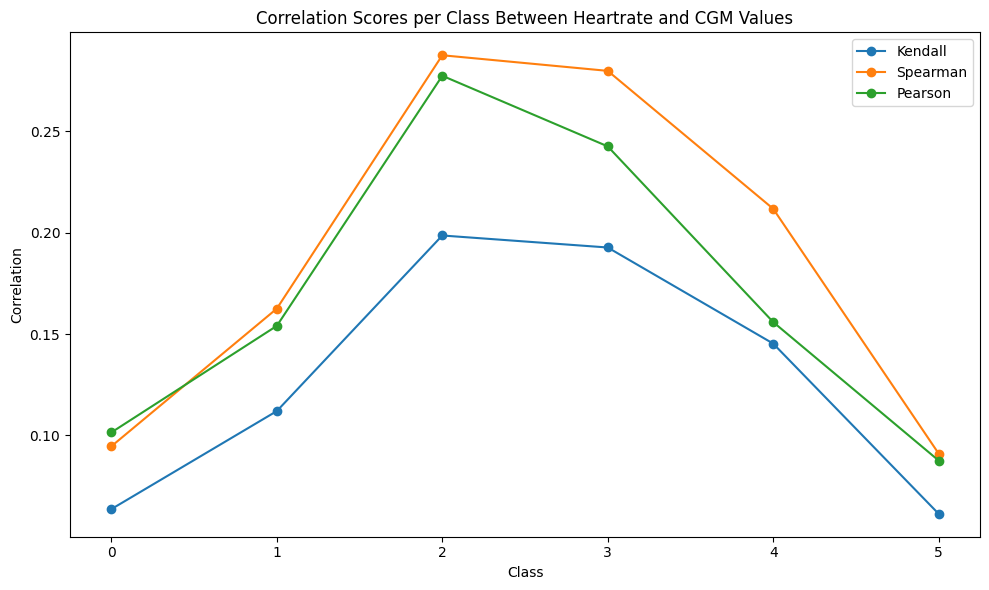

In [ ]:
# plots the correaltion scores for each method and each class
df_correlations = pd.DataFrame({
    "Kendall": kendall_by_class,
    "Spearman": spearman_by_class,
    "Pearson": pearson_by_class
}).T

df_correlations.T.plot(marker='o', figsize=(10, 6)) 
plt.title("Correlation Scores per Class Between Heartrate and CGM Values")
plt.xlabel("Class")
plt.ylabel("Correlation")
plt.tight_layout()
plt.show()